<a href="https://colab.research.google.com/github/emanbuc/ultrasonic-vision/blob/main/notebooks/multiclass_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Addestramento classificatore con SciKit Learn

reference https://scikit-learn.org/stable/modules/multiclass.html


## Python Data Science Environment
 
Attenzione alle versione: il salvataggio su file ed il successivo caricamento dei modelli addestrati funziona bene solo se nell'ambiente di sviluppo (addestramento) e produzione (runtime) sono presenti le stesse versioni delle librerie. I package critici sono:

In [1]:
import sklearn
import numpy as np
import sklearn 
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
import onnx,skl2onnx
import onnxruntime as ort
print("onnx: ", onnx.__version__)
print("onnxruntime: ", ort.__version__)
print("skl2onnx: ", skl2onnx.__version__)

from platform import python_version
print("python: ", python_version())


numpy: 1.19.2
scikit-learn: 0.23.2
onnx:  1.8.0
onnxruntime:  1.6.0
skl2onnx:  1.7.0
python:  3.8.5


In [2]:
import pandas
import matplotlib.pyplot as plt

## Analisi dati

Per un'analisi più estesa dei dati vedi anche il notebook [analisi dati sensori](https://github.com/emanbuc/ultrasonic-vision/blob/main/notebooks/analisi_dati_sensori.ipynb)



     HCSR04_001  HCSR04_002  HCSR04_003  HCSR04_004  HCSR04_005  HCSR04_006  \
0         55.59       16.09       54.78       17.55       51.73       57.48   
1         56.40       16.06       55.29       17.48       51.27       57.42   
2         56.32       16.04       54.86       17.55       51.26       58.30   
3         55.08       15.96       54.87       17.62       51.24       58.28   
4         55.11       15.96       55.22       17.57       51.71       57.86   
..          ...         ...         ...         ...         ...         ...   
302       53.43       55.59       55.07       52.16       51.25       51.77   
303       53.40       55.57       55.13       52.10       51.71       52.60   
304       53.83       55.60       55.14       52.53       51.29       51.70   
305       53.40       55.97       55.08       52.22       51.17       51.74   
306       53.41       55.63       54.76       52.12       51.24       52.51   

     HCSR04_007  ObjectClass  
0         96.38  BAL

<ipython-input-3-4408cf75db7e>:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data.iloc[:,0:7].hist(ax = ax)


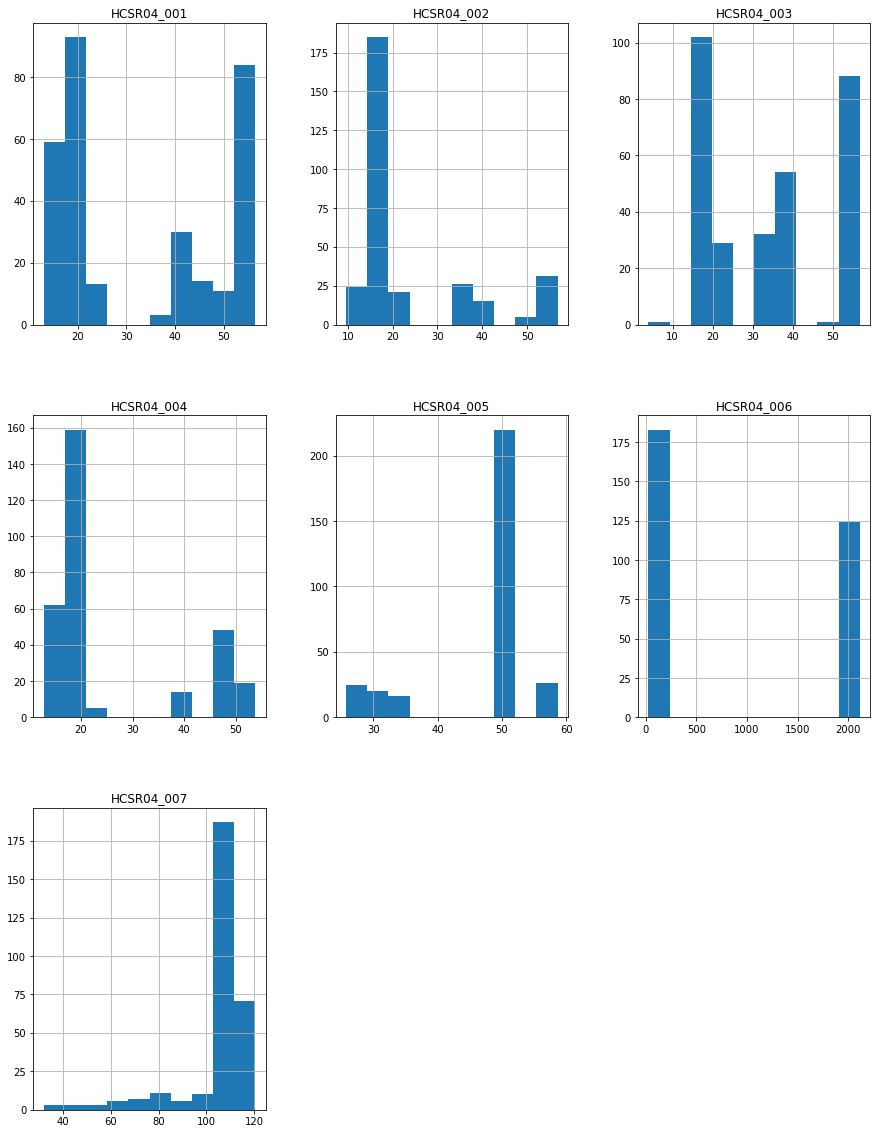

In [3]:

url = "https://raw.githubusercontent.com/emanbuc/ultrasonic-vision/main/dataset/20210102_alldata_outlier_removed.csv"
names = ['HCSR04_001', 'HCSR04_002', 'HCSR04_003', 'HCSR04_004', 'HCSR04_005', 'HCSR04_006', 'HCSR04_007',"ObjectClass"]
data = pandas.read_csv(url, usecols=names)

print(data)
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.iloc[:,0:7].hist(ax = ax)
plt.show()

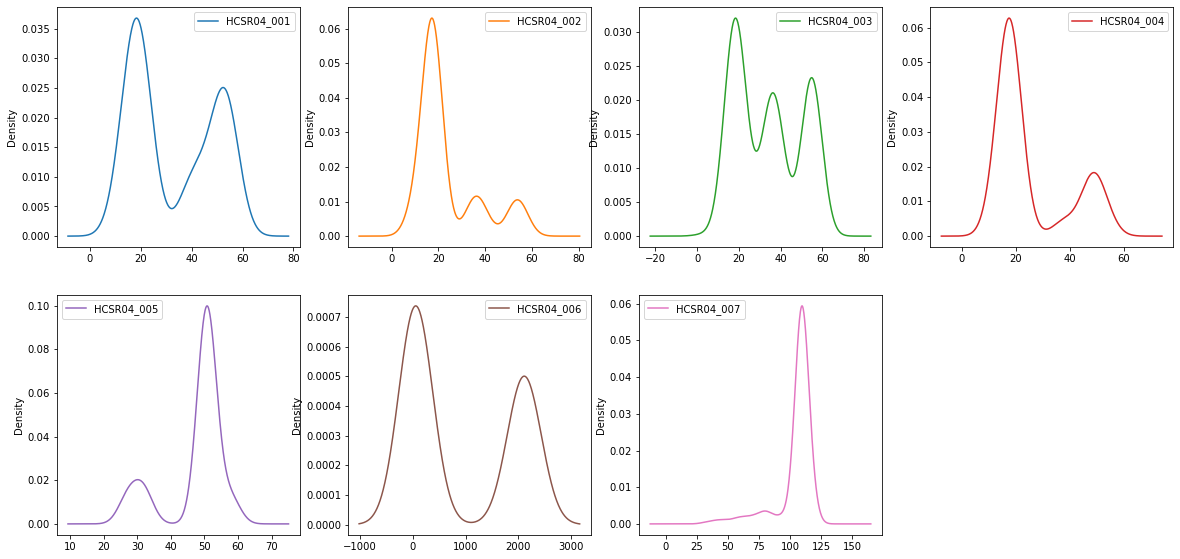

In [4]:
data.plot(kind='density', subplots=True, layout=(3,4), sharex=False, figsize=(20,15))
plt.show()

Il range delle distanze stimate dai sensori HCSR04_007 e HCSR04_006 sono molto supeiore ai valori attesi. L'analisi dei dati provenienti da questi sensori è stata approfondita dei paragrafi che seguono.

## Analisi dati HCSR04-007

Distribuzione dei dati nei diversi esperimenti

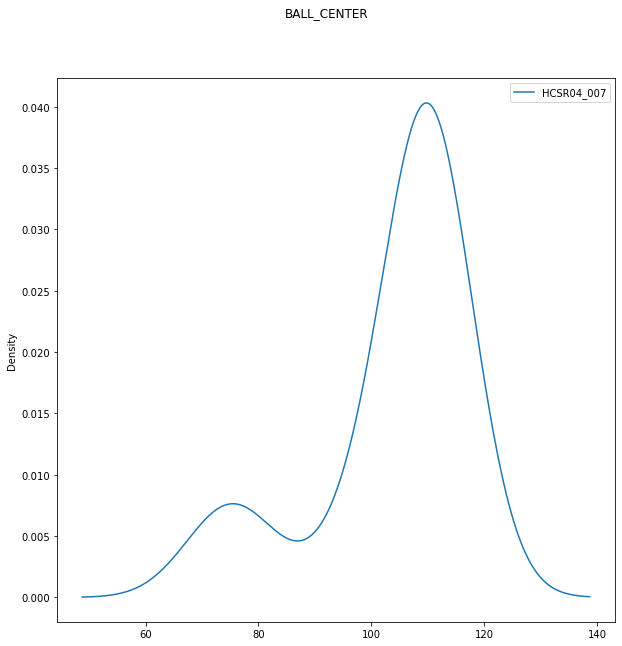

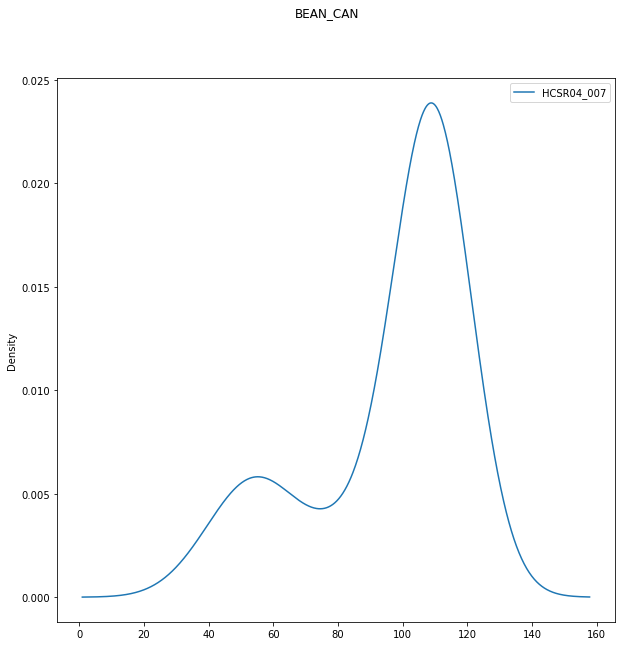

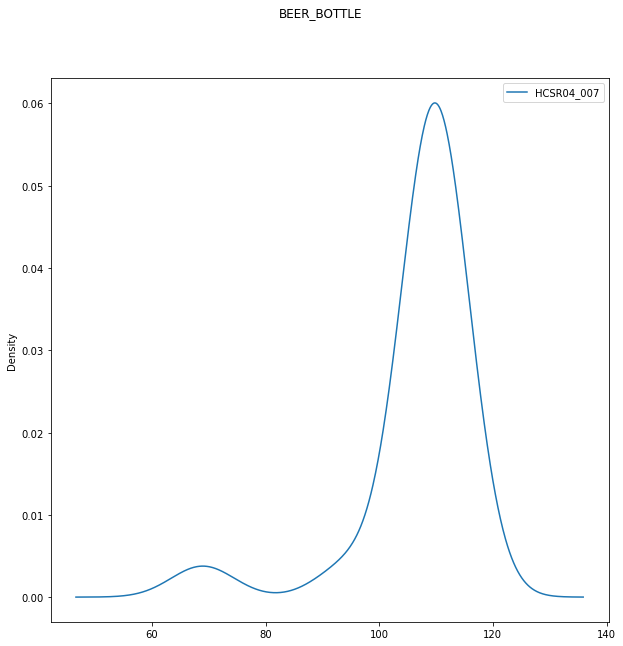

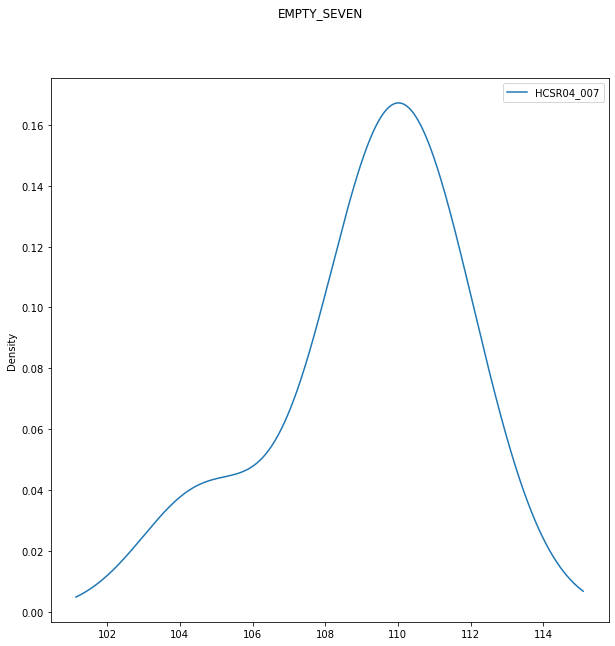

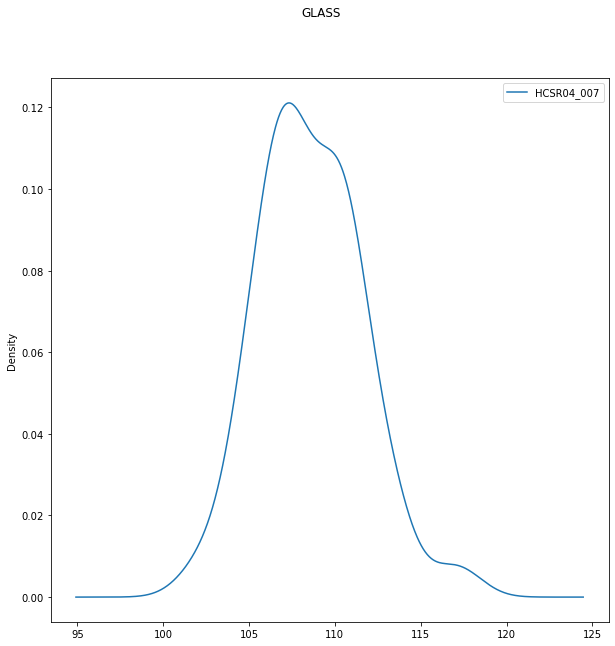

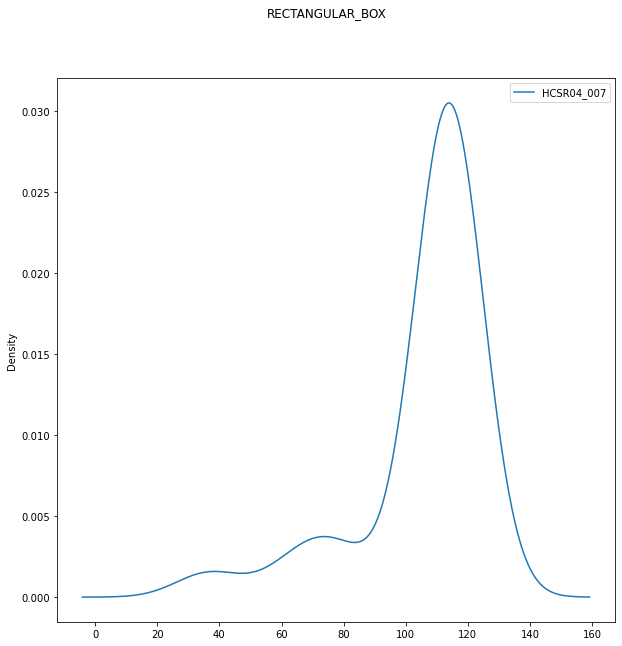

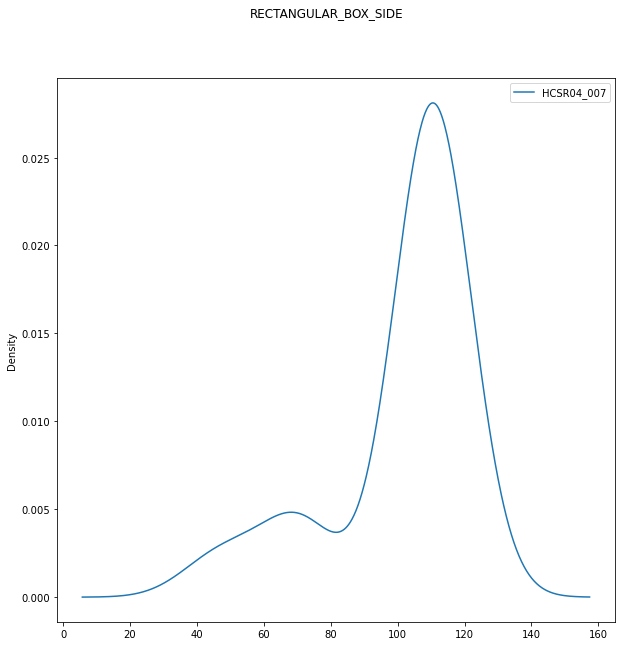

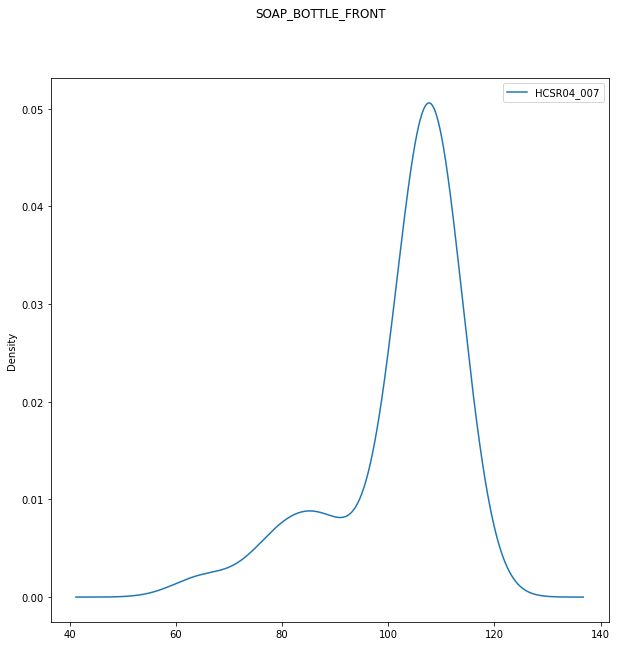

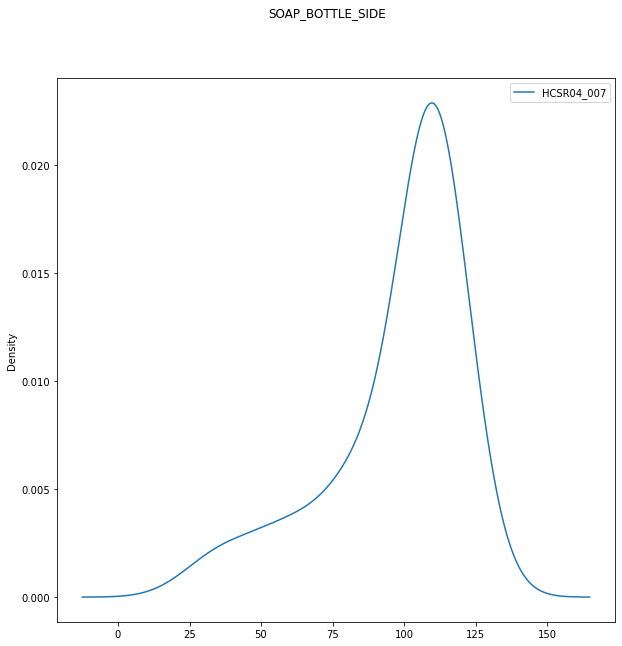

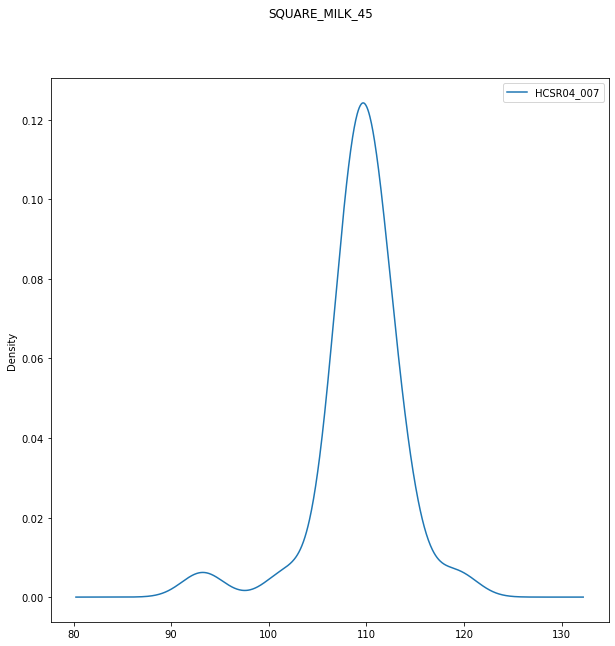

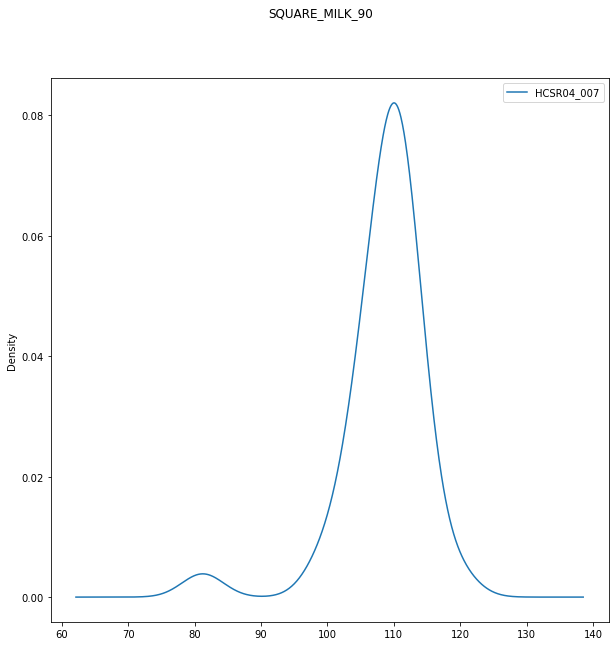

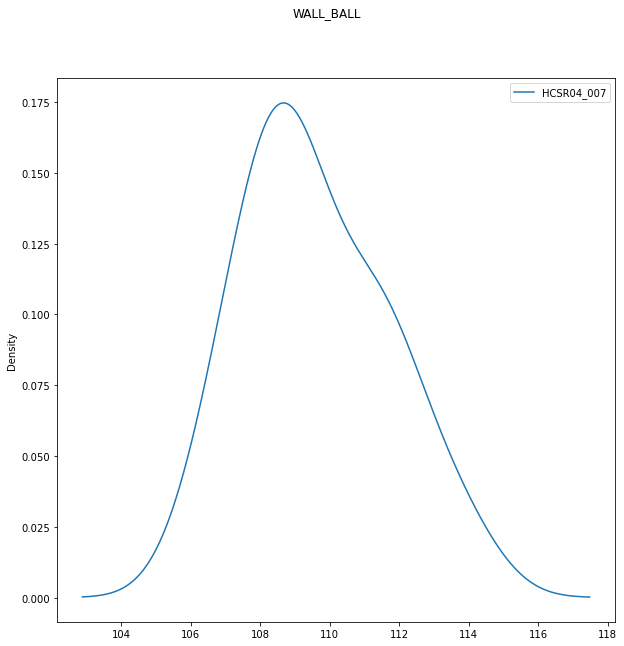

In [5]:
data_HCSR04_007 = data.loc[:,['HCSR04_007','ObjectClass']]

for name, group in data_HCSR04_007.groupby(['ObjectClass']):
    # print the name of the regiment
    group.plot(kind='density', subplots=True, layout=(1,1), sharex=False, figsize=(10,10), title=name)

La distibuzione delle stime fornite da HCSR04_007 nei vari esperimenti è diversa. Sembra quindi ragionevole ipotizzare che, anche se le distanze stimate sono fortemente errate, questi dati  potrebbero quindi contenere informazione utile alla classificazione degli oggetti. Questa ipotesi sarà poi verificata sul campo.

## Analisi dati HCSR-04_006

    HCSR04_006  ObjectClass
0        57.48  BALL_CENTER
1        57.42  BALL_CENTER
2        58.30  BALL_CENTER
3        58.28  BALL_CENTER
4        57.86  BALL_CENTER
5        57.44  BALL_CENTER
6        58.77  BALL_CENTER
7        57.43  BALL_CENTER
8        57.84  BALL_CENTER
9        54.02  BALL_CENTER
10       54.45  BALL_CENTER
11       54.91  BALL_CENTER
12       54.01  BALL_CENTER
13       54.45  BALL_CENTER
14       54.68  BALL_CENTER
15       54.43  BALL_CENTER
16       54.89  BALL_CENTER
17       54.04  BALL_CENTER
18       54.28  BALL_CENTER
19       54.86  BALL_CENTER
    HCSR04_006 ObjectClass
20     2115.51    BEAN_CAN
21     2114.53    BEAN_CAN
22     2114.58    BEAN_CAN
23     2114.95    BEAN_CAN
24     2114.89    BEAN_CAN
25     2114.74    BEAN_CAN
26     2115.73    BEAN_CAN
27     2115.19    BEAN_CAN
28     2115.16    BEAN_CAN
29     2115.65    BEAN_CAN
30     2115.82    BEAN_CAN
31     2115.00    BEAN_CAN
32     2114.92    BEAN_CAN
33     2114.63    BEAN_CAN
34     

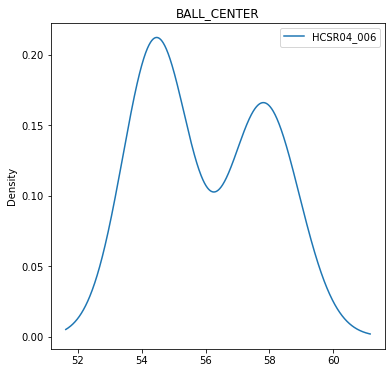

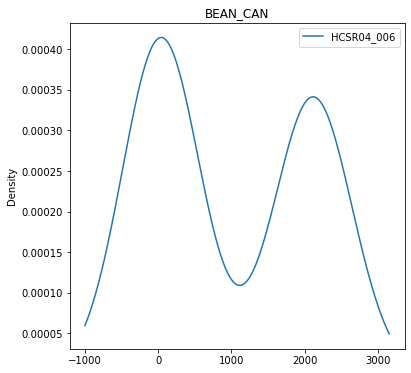

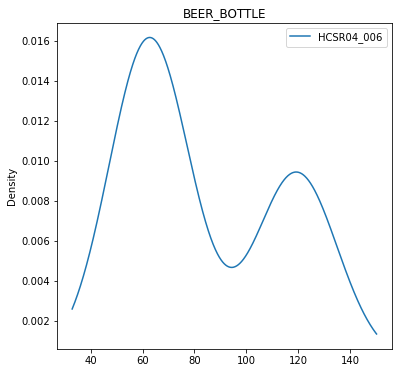

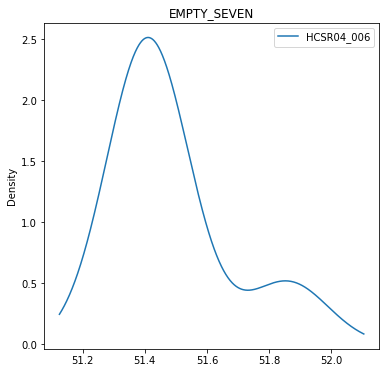

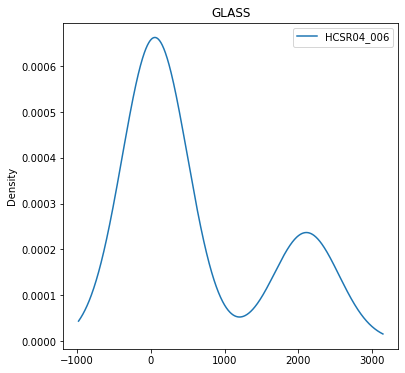

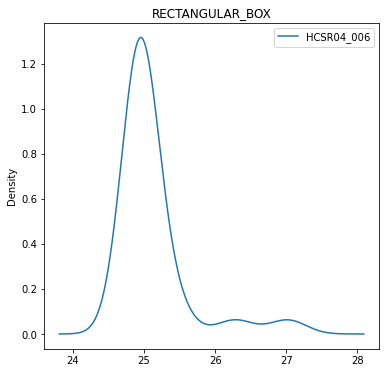

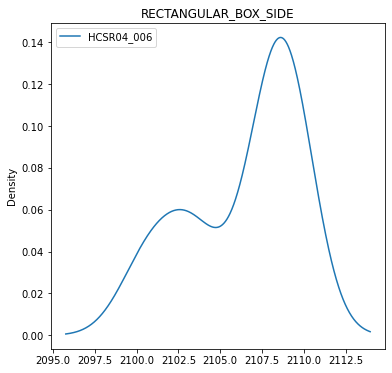

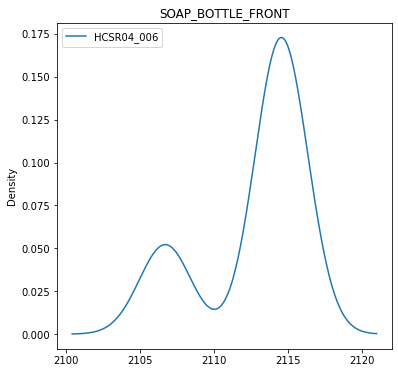

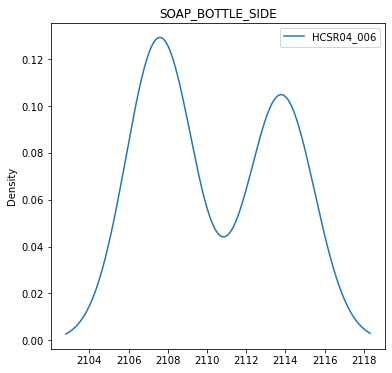

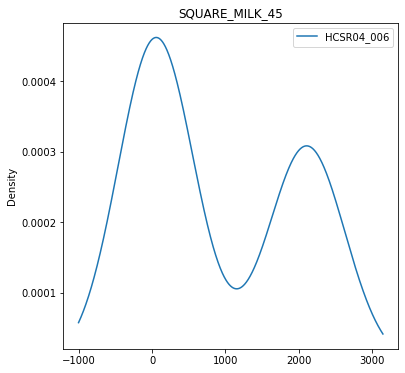

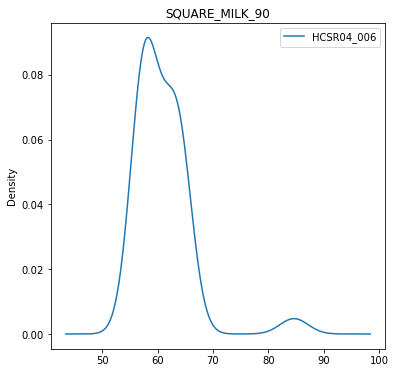

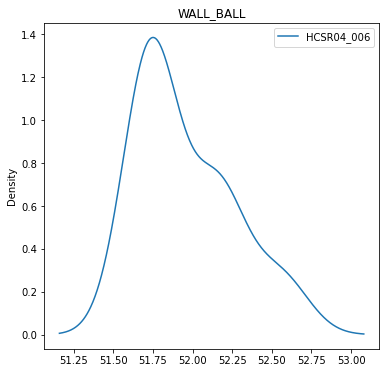

In [6]:
data_HCSR04_006 = data.loc[:,['HCSR04_006','ObjectClass']]

for name, group in data_HCSR04_006.groupby(['ObjectClass']):
    # print the name of the regiment
    group.plot(kind='density', layout=(1,1), sharex=False, figsize=(6,6), title=name)
    print(group)

Un numero significativo di stime fornite da HCSR04_006 sono intorno al valore 2000 cm. Si tratta di misure ottenute quando il bersaglio non occupava completamente l'area di rilevamento del sensore.
Forse le misure defivano da fenomeni di diffrazzione sui bordi o da echi che hganno raggiunto il ricevitore dopo riflessioni multiple.

Non è stato possibile determinare con sicurezza il grado di riproducibilità di queste misure che sembrano dipendere fortemente dalla posizione del bersaglio rispetto al sensore.

Una percentuale significativa delle distanze si trova in un intorno di 2000 nel caso di alcuni esperimenti questo il valore atteso della distribuzione è vicino a 2000. Non è quindi ragionevole consederare questi dati come outlier.

## Dataset di training

Sono stati preparati due distinti dataset di training: 
- dataset completo 
- senza dati HCSR-04_007

I due dataset saranno utiolizzati per addestrare diversi modelli con lo scopo di verificare sperimentalmente quale modello ha le migliori prestazioni in condizioni operative realistiche

In [7]:
x_train_all = data[['HCSR04_001','HCSR04_002','HCSR04_003','HCSR04_004','HCSR04_005','HCSR04_006','HCSR04_007']]
y_train_all = data[['ObjectClass']]

In [8]:
x_train_NO_007 = data[['HCSR04_001','HCSR04_002','HCSR04_003','HCSR04_004','HCSR04_005','HCSR04_006']]
y_train_NO_007 = data[['ObjectClass']]

In [9]:
x_test= [30,35,30,35,20,50,100]

## Classificatore Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
clf = make_pipeline(StandardScaler(), RandomForestClassifier())
clf.fit(x_train_all, np.ravel(y_train_all))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [11]:
import pickle

filename='../models/rf_classificator_model_pickle_outline_removed.pkl'
filenameONNX='../models/rf_classificator_model_pickle_outline_removed.onnx'
pickle.dump(clf, open(filename, 'wb'))

In [12]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('distances', FloatTensorType([None, 7]))]
onx = convert_sklearn(clf, initial_types=initial_type)
with open(filenameONNX, "wb") as f:
    f.write(onx.SerializeToString())

# Only for google.colab

#from google.colab import files
# files.download(filename)
# files.download(filenameONNX)

In [13]:
clf = make_pipeline(StandardScaler(), RandomForestClassifier())
clf.fit(x_train_NO_007, np.ravel(y_train_NO_007))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [14]:
import pickle

filename='../models/rf_classificator_model_pickle_outline_removed_NO_007.pkl'
filenameONNX='../models/rf_classificator_model_pickle_outline_removed_NO_007.onnx'
pickle.dump(clf, open(filename, 'wb'))

In [15]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('distances', FloatTensorType([None, 7]))]
onx = convert_sklearn(clf, initial_types=initial_type)
with open(filenameONNX, "wb") as f:
    f.write(onx.SerializeToString())

# Only for google.colab

#from google.colab import files
# files.download(filename)
# files.download(filenameONNX)

## Addestramento modello SVM

### Modello addestrato su dataset completo

In [16]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train_all, np.ravel(y_train_all))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

#### Salvataggio Modello addestrato

In [17]:
import pickle

filename='../models/svm_classificator_model_pickle_outline_removed.pkl'
filenameONNX='../models/svm_classificator_model_pickle_outline_removed.onnx'
pickle.dump(clf, open(filename, 'wb'))

In [18]:
# convert_sklearn non supporata questo modello

#from skl2onnx import convert_sklearn
#from skl2onnx.common.data_types import FloatTensorType

#initial_type = [('distances', FloatTensorType([None, 7]))]
#onx = convert_sklearn(clf, initial_types=initial_type)
#with open(filenameONNX, "wb") as f:
#    f.write(onx.SerializeToString())

# Only for google.colab

#from google.colab import files
# files.download(filename)
# files.download(filenameONNX)

#### Test Classificatore

In [19]:
load_lr_model =pickle.load(open(filename, 'rb'))
load_lr_model.predict([x_test])

array(['SQUARE_MILK_90'], dtype=object)

### Modello addestrato senza HCSR04_007

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train_NO_007, np.ravel(y_train_NO_007))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [21]:
cross_val_score(clf, x_train_all, np.ravel(y_train_all), cv=3, scoring="accuracy")

array([0.69902913, 0.84313725, 0.7745098 ])

#### Salvataggio Modello addestrato

In [22]:
import pickle
filename='../models/svm_classificator_model_pickle_outline_removed_NO_007.pkl'
filenameONNX='../models/svm_classificator_model_pickle_outline_removed_NO_007.onnx'
pickle.dump(clf, open(filename, 'wb'))

In [23]:
#from skl2onnx import convert_sklearn
f#rom skl2onnx.common.data_types import FloatTensorType

#initial_type = [('distances', FloatTensorType([None, 7]))]
#onx = convert_sklearn(clf, initial_types=initial_type)
#with open(filenameONNX, "wb") as f:
   # f.write(onx.SerializeToString())

# Only for google.colab

#from google.colab import files
# files.download(filename)
# files.download(filenameONNX)

<_io.BufferedWriter name='../models/rf_classificator_model_pickle_outline_removed_NO_007.onnx'>

#### Test Classificatore

In [24]:
x_test[0:6]

[30, 35, 30, 35, 20, 50]

In [25]:
load_lr_model =pickle.load(open(filename, 'rb'))
load_lr_model.predict([x_test[0:6]])

array(['SQUARE_MILK_90'], dtype=object)

## Addestramento LinearSVC

reference: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import numpy as np
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0))
clf.fit(x_train_all, np.ravel(y_train_all))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0))])

In [27]:
cross_val_score(clf, x_train_all, np.ravel(y_train_all), cv=3, scoring="accuracy")

array([0.76699029, 0.84313725, 0.7745098 ])

In [28]:
import pickle
filename='linearSVC_classificator_model_pickle_outline_removed.pkl'
filenameONNX='linearSVC_classificator_model_pickle_outline_removed.onnx'
pickle.dump(clf, open(filename, 'wb'))

In [29]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('distances', FloatTensorType([None, 7]))]
onx = convert_sklearn(clf, initial_types=initial_type)
with open(filenameONNX, "wb") as f:
    f.write(onx.SerializeToString())

# Only for google.colab

#from google.colab import files
# files.download(filename)
# files.download(filenameONNX)

Test

In [30]:
load_lr_model =pickle.load(open(filename, 'rb'))
load_lr_model.predict([x_test])

array(['SQUARE_MILK_45'], dtype=object)

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import numpy as np
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0))
clf.fit(x_train_NO_007, np.ravel(y_train_NO_007))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0))])

In [32]:
import pickle
filename='linearSVC_classificator_model_pickle_outline_removed_NO_007.pkl'
filenameONNX='linearSVC_classificator_model_pickle_outline_removed_NO_007.onnx'
pickle.dump(clf, open(filename, 'wb'))

In [33]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('distances', FloatTensorType([None, 7]))]
onx = convert_sklearn(clf, initial_types=initial_type)
with open(filenameONNX, "wb") as f:
    f.write(onx.SerializeToString())

# Only for google.colab

#from google.colab import files
# files.download(filename)
# files.download(filenameONNX)

## Addestramento KNN

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
clf.fit(x_train_all, np.ravel(y_train_all))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [35]:
cross_val_score(clf, x_train_all, np.ravel(y_train_all), cv=3, scoring="accuracy")

array([0.81553398, 0.95098039, 0.75490196])

In [36]:
import pickle
filename='knn_classificator_model_pickle_outline_removed.pkl'
filenameONNX='knn_classificator_model_pickle_outline_removed.onnx'
pickle.dump(clf, open(filename, 'wb'))

In [37]:
# Not implemented in convert_sklearn for KNN model
#from skl2onnx import convert_sklearn
#from skl2onnx.common.data_types import FloatTensorType

#initial_type = [('distances', FloatTensorType([None, 7]))]
#onx = convert_sklearn(clf, initial_types=initial_type)
#with open(filenameONNX, "wb") as f:
#    f.write(onx.SerializeToString())

# Only for google.colab

#from google.colab import files
# files.download(filename)
# files.download(filenameONNX)

Test

In [38]:
load_lr_model =pickle.load(open(filename, 'rb'))
load_lr_model.predict([x_test])

array(['SQUARE_MILK_90'], dtype=object)

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
clf.fit(x_train_NO_007, np.ravel(y_train_NO_007))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [40]:
import pickle
filename='knn_classificator_model_pickle_outline_removed_NO_007.pkl'
filenameONNX='knn_classificator_model_pickle_outline_removed_NO_007.onnx'
pickle.dump(clf, open(filename, 'wb'))

In [41]:
# Not implemented in convert_sklearn for KNN model
# from skl2onnx import convert_sklearn
# from skl2onnx.common.data_types import FloatTensorType

# initial_type = [('distances', FloatTensorType([None, 7]))]
# onx = convert_sklearn(clf, initial_types=initial_type)
# with open(filenameONNX, "wb") as f:
 #   f.write(onx.SerializeToString())

# Only for google.colab

#from google.colab import files
# files.download(filename)
# files.download(filenameONNX)